Github pages part

In [4]:
from sklearn.decomposition import PCA
import hopsworks
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pickle

In [5]:
project = hopsworks.login(api_key_value="wOWQmzzHeITT5wlJ.FkOButuQ3XpDXSUO1LnTuaNfD7SPWolfF1hateoistsLFFsBF7upULn5z6qKPOIB")

fs = project.get_feature_store() 
headline_fg = fs.get_feature_group(
    name='headlines_new', 
    version=1,
)
headline_df = headline_fg.read()
headline_df = headline_df.sort_values(by='pubdate')


mr = project.get_model_registry()
# dim reduction
model = mr.get_model("PCA_Model", version=1)
model_dir = model.download()
print(f"Model downloaded to: {model_dir}")
with open(f"{model_dir}/pca_model.pkl", "rb") as f:
    pca_model = pickle.load(f)

# predict cluster
model = mr.get_model("KMeans_Model", version=1)
model_dir = model.download()
print(f"Model downloaded to: {model_dir}")
with open(f"{model_dir}/kmeans_model.pkl", "rb") as f:
    kmeans_model = pickle.load(f)


2024-12-12 21:59:16,832 INFO: Closing external client and cleaning up certificates.
Connection closed.
2024-12-12 21:59:16,841 INFO: Initializing external client
2024-12-12 21:59:16,844 INFO: Base URL: https://c.app.hopsworks.ai:443
2024-12-12 21:59:17,823 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1163414
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 
Model downloaded to: /var/tmp/c551633c-cf38-40ab-ba62-78f3dad2d22a/PCA_Model/1
Model downloaded to: /var/tmp/93cc3f72-7f25-4a6a-ab87-e4eb244d6bde/KMeans_Model/1


For different time scales

In [6]:
def df_between_dates(df, start_date, end_date):
    return df[(df['pubdate'] >= start_date) & (df['pubdate'] <= end_date)]

df_week = df_between_dates(headline_df, '2024-11-01', '2024-12-3')


now = datetime.now()
days3 = now + timedelta(days=-3)
past_week = now + timedelta(weeks=-1)
past_month = now + relativedelta(months=-1)
past_year = now + relativedelta(years=-1)


#df_week = df_between_dates(headline_df, '2024-11-01', '2024-12-3')
dfs = {}
dfs['day3'] = df_between_dates(headline_df, days3.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))
dfs['week'] = df_between_dates(headline_df, past_week.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))
dfs['month'] = df_between_dates(headline_df, past_month.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))
dfs['year'] = df_between_dates(headline_df, past_year.strftime("%Y-%m-%d"), now.strftime("%Y-%m-%d"))

In [7]:
# encode all headlines to vectors
emb_model = SentenceTransformer('all-MiniLM-L6-v2')
headlines = {}
embeddings = {}
for key in dfs.keys(): # TODO only choose a few keys
    headlines[key]= dfs[key]['title'].tolist()
    embeddings[key] = emb_model.encode(headlines[key])

2024-12-12 21:59:34,024 INFO: Use pytorch device_name: cpu
2024-12-12 21:59:34,026 INFO: Load pretrained SentenceTransformer: all-MiniLM-L6-v2


Batches: 0it [00:00, ?it/s]

Batches: 0it [00:00, ?it/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/445 [00:00<?, ?it/s]

error
error


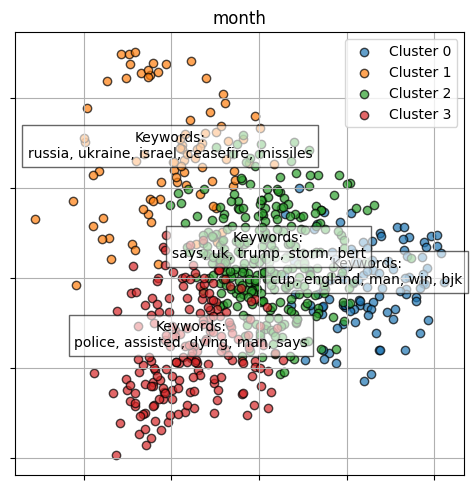

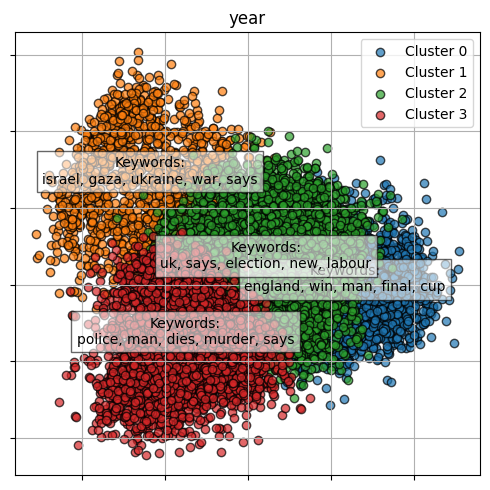

In [16]:
# make clusters and plot
def extract_keywords(clustered_headlines):
    vectorizer = CountVectorizer(stop_words='english')
    keywords = {}
    for cluster_id, headlines in clustered_headlines.items():
        word_counts = vectorizer.fit_transform(headlines)
        word_freq = Counter(dict(zip(vectorizer.get_feature_names_out(), word_counts.sum(axis=0).A1)))
        keywords[cluster_id] = [word for word, freq in word_freq.most_common(5)]  # Top 5 keywords
    return keywords

def plot_clusers(keywords, optimal_clusters, embeddings_2d, clusters, title):
    plt.figure(figsize=(5, 5))
    for cluster in range(optimal_clusters):
        cluster_points = embeddings_2d[clusters == cluster]
        plt.scatter(
            cluster_points[:, 0], cluster_points[:, 1],
            label=f"Cluster {cluster}", alpha=0.7, edgecolors='k'
        )
        cluster_center = cluster_points.mean(axis=0)
        plt.text(cluster_center[0], cluster_center[1],
                 f"Keywords:\n{', '.join(keywords[cluster])}",
                 fontsize=10, bbox=dict(facecolor='white', alpha=0.6), ha='center')
    plt.title(title)
    #plt.xlabel("PC 1")
    #plt.ylabel("PC 2")
    plt.legend()
    plt.gca().set_xticklabels([])
    plt.gca().set_yticklabels([])
    plt.grid()
    plt.tight_layout()
    plt.savefig(f'docs/cluster_{title}.png')
    plt.show()
    
def forward(kmeans,pca,embeddings, headlines, title='PCA'):
    clusters = kmeans.predict(embeddings)
    embeddings_2d = pca.transform(embeddings)
    df2 = pd.DataFrame({'headline': headlines, 'cluster': clusters})
    clustered_headlines = df2.groupby('cluster')['headline'].apply(list)

    keywords = extract_keywords(clustered_headlines)
    plot_clusers(keywords, kmeans_model.n_clusters, embeddings_2d, clusters, title)

for key in embeddings.keys(): # gives error if no fresh data exists
    try:
        forward(kmeans_model,pca_model,embeddings[key], headlines[key], title=key)
    except:
        print('error')

Make one figure from all four

In [17]:
images = ["docs/cluster_day3.png",
          "docs/cluster_week.png",
          "docs/cluster_month.png",
          "docs/cluster_year.png"]

img1 = Image.open(images[0])
img2 = Image.open(images[1])
img3 = Image.open(images[2])
img4 = Image.open(images[3])

size = img1.size 
img2 = img2.resize(size)
img3 = img3.resize(size)
img4 = img4.resize(size)

combined_width = size[0] * 2
combined_height = size[1] * 2
combined_image = Image.new("RGBA", (combined_width, combined_height))

combined_image.paste(img4, (0, 0))  # Top-left
combined_image.paste(img3, (size[0], 0))  # Top-right
combined_image.paste(img2, (0, size[1]))  # Bottom-left
combined_image.paste(img1, (size[0], size[1]))  # Bottom-right

combined_image.save("docs/combined_image.png")